**Learning distribution with Neural Spline Flow**

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from jax.experimental import optix
import haiku as hk
import tensorflow_probability as tfpp; tfp = tfpp.experimental.substrates.jax
from functools import partial

from nsec.models.nflow.nsf import NeuralSplineCoupling, NeuralSplineFlow
from nsec.datasets.gaussian_mixture import get_gm
from nsec.utils import display_score_gm

tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("TFP Version", tfpp.__version__)
print("JAX  Version",jax.__version__)
print("Haiku  Version",hk.__version__)

TFP Version 0.11.0
JAX  Version 0.1.73
Haiku  Version 0.0.2


```
class NeuralSplineCoupling(hk.Module):
    def __init__(self, nunits, name, nbins=32):
        super(NeuralSplineCoupling, self).__init__(name=name)
        self.nunits = nunits
        self.nbins = nbins
        
    def bin_positions(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins])
        return jax.nn.softmax(x, axis=-1) *  (2. - self.nbins * 1e-2) + 1e-2
  
    def slopes(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins - 1])
        return jax.nn.softplus(x) + 1e-2
    
    def __call__(self, x, nunits):
        #net = jax.nn.leaky_relu(hk.Linear(128)(x))
        #net = jax.nn.leaky_relu(hk.Linear(128)(net))
        net = jnp.tanh(hk.Linear(128)(x))
        net = jnp.tanh(hk.Linear(128)(net))

        bin_widths = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        bin_heights = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        knot_slopes = self.slopes(hk.Linear(nunits*(self.nbins-1))(net))

        return tfb.RationalQuadraticSpline(
                bin_widths=bin_widths,
                bin_heights=bin_heights,
                knot_slopes=knot_slopes)
```

```
class NeuralSplineFlow(hk.Module):
    def __init__(self):
        super(NeuralSplineFlow, self).__init__()
    
    def __call__(self, x):
        spline1 = NeuralSplineCoupling(1, 'coupling1')
        spline2 = NeuralSplineCoupling(1, 'coupling2')
        spline3 = NeuralSplineCoupling(1, 'coupling3')

        # Computes the likelihood of these x
        chain = tfb.Chain([
            tfb.Scale(10),
            RealNVP(1, bijector_fn=spline1),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline2),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline3),
            tfb.Permute([1,0]),
            tfb.Scale(0.1)
        ])

        nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(2,))

        return nvp.log_prob(x)
```

In [9]:
def forwardNF(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
model_NF = hk.transform(forwardNF, apply_rng=True)

In [10]:
optimizer = optix.adam(1e-4)
rng_seq = hk.PRNGSequence(42)

In [11]:

"""
# Now let's draw ou famous two moons
from sklearn import datasets

# Experimenting with only a fixed number of points
batch_size=512

def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}
"""
from nsec.datasets.two_moons import get_two_moons
two_moons = get_two_moons(0.05)
distribution = two_moons
true_score = jax.vmap(jax.grad(distribution.log_prob))

batch_size = 512

def make_samples(rng_seq, n_samples, gm):
    return gm.sample(n_samples, seed = next(rng_seq))

def get_batch():
    x = make_samples(rng_seq, batch_size,distribution)
    return {'x': x}

def make_mixture(rng_seq, n_samples, gm):
    return gm.sample(n_samples, seed = next(rng_seq))

noise = 1.
p = 0.2
batch_size=1000

gm = get_gm(p, noise)

distribution = gm

def get_batch():
    x = make_mixture(rng_seq, batch_size,gm)
    return {'x': x}

true_score = jax.vmap(jax.grad(distribution.log_prob))


In [12]:
@jax.jit
def loss_fn(params, rng_key, batch):
    log_prob = model_NF.apply(params, rng_key, batch['x'])
    return -jnp.mean(log_prob)

In [13]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [14]:
params = model_NF.init(next(rng_seq), jnp.zeros((1, 2)))
opt_state = optimizer.init(params)

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/br263581/opt/anaconda3/envs/co

In [15]:
losses = []
for step in range(2000):
    batch = get_batch()
    loss, params, opt_state = update(params, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(loss)

2.4737506
1.884132
1.5781745
1.4697741
1.3218837
1.1690726
1.05673
0.84598684
0.7745509
0.666816
0.66688174
0.64261293
0.61867887
0.5407833
0.56385726
0.4995059
0.56904316
0.52711076
0.36571127
0.4602614


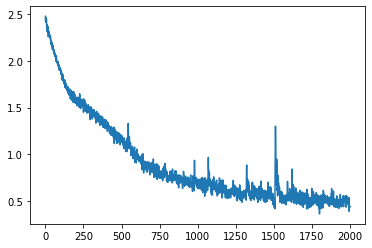

In [16]:
plot(losses)

In [17]:
#xc,yc = meshgrid(linspace(-1.5,2.5,204),linspace(-1.,1.5,128))
xc,yc = meshgrid(linspace(-7.,7.,128),linspace(-7.,7.,128))
Z = stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
print(Z.shape, Z.dtype)

(16384, 2) float32


In [19]:
S = model_NF.apply(params, next(rng_seq), Z)

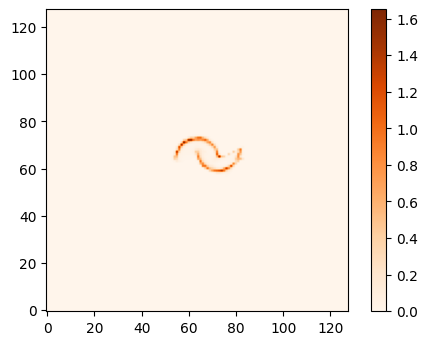

In [20]:
figure(dpi=100)
#imshow(exp(S.reshape((128,204))), cmap='Oranges', origin='lower')
imshow(exp(S.reshape((128,128))), cmap='Oranges', origin='lower')
#axis('off')
colorbar()

In [21]:
# Let's compute the score function (gradient of the log likelihood)
log_prob = partial(model_NF.apply, params, next(rng_seq))
log_prob(jnp.zeros(2).reshape(1,2)).shape

def log_prob_reshaped(x):
    return jnp.reshape(log_prob(x), ())

score = jax.vmap(jax.grad(log_prob_reshaped))

In [22]:
v_batched = jnp.zeros(10).reshape(5,1,2)
score(v_batched)

DeviceArray([[[55.70655 , 19.722857]],

             [[55.70655 , 19.722857]],

             [[55.70655 , 19.722857]],

             [[55.70655 , 19.722857]],

             [[55.70655 , 19.722857]]], dtype=float32)

In [25]:
#display_score_gm(score, distribution, dpi=150)

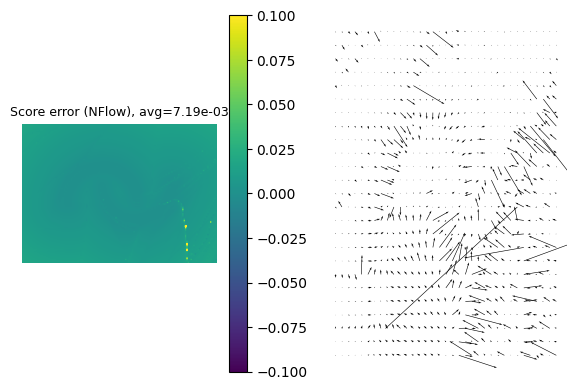

In [26]:
from nsec.utils import display_score_error_gm, display_score_error_two_moons

scores = [score]
labels = ['NFlow']

plt.figure(dpi=100)
display_score_error_two_moons(true_score, scores, labels, distribution=None, is_amortized=False, is_reg=False, scale=4, offset=[0., 0.], is_NF=True)

In [ ]:
distribution=None
is_amortized=False
is_reg=False
scale=4
offset=[0., 0.]
is_NF=True
estimated_scores = scores

scale = scale
offset = jnp.array(offset)
d_offset = jnp.array([.5, .25])

c1 = scale * (jnp.array([-.7, -0.5])) + d_offset + offset
c2 = scale * (jnp.array([.7, 0.5])) + d_offset + offset
#X = jnp.arange(c1[0], c2[0], 0.1)
#Y = jnp.arange(c1[1], c2[1], 0.1)
n = 100
X = jnp.linspace(c1[0], c2[0], int(n*7/5))
Y = jnp.linspace(c1[1], c2[1], n)

if distribution:
    _x, _y = jnp.meshgrid(jnp.arange(0, len(X), 1), jnp.arange(0, len(Y), 1))
    Z = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))
    S = distribution.log_prob(Z)
    dist = jnp.exp(S.reshape((len(Y), len(X))))

if is_NF:
    points = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 1, 2))
else:
    points = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))

true_s = true_score(points.reshape((-1, 2)))
true_s = true_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(true_s)
n_s = len(labels)
estimated_vector_fileds = []
errors = []

for score in estimated_scores:
    if is_amortized:
        if is_reg:
            estimated_s, state = score(points, 0.0*jnp.ones((len(points),1)))
        else:
            estimated_s = score(points, 0.0*jnp.ones((len(points),1)))
    else:
        if is_reg:
            estimated_s, state = score(points)
        else:
            estimated_s = score(points)
    estimated_s = estimated_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_s)
    estimated_vector_fileds.append(estimated_s)
    
    print(estimated_s.shape)
    print(true_s.shape)
    errors.append(jnp.linalg.norm(estimated_s - true_s, axis=2))

v_min = jnp.min([jnp.min(e) for e in errors])
v_max = jnp.max([jnp.max(e) for e in errors])

for i in range(n_s):
    plt.subplot(n_s, 2, 2*i+1)
    plt.imshow(errors[i], origin='lower', vmin=v_min, vmax=v_max)
    plt.axis('off')
    plt.colorbar()
    if distribution:
        plt.contour(_x, _y, dist, levels=[1], colors='white')
    plt.title('Score error ({}), avg={:.2e}'.format(labels[i], jnp.mean(errors[i])), fontsize=9)
    plt.subplot(n_s, 2, 2*i+2)

    g = estimated_vector_fileds[i]

    print(X[::4].shape)
    plt.quiver(X[::4], Y[::4], g[::4,::4,0], g[::4,::4,1])
    plt.axis('off')

plt.tight_layout()